In [ ]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
df = pd.read_csv('Titanic-Dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Типы переменных:**

PassengerId (ID пассажира) - номинальная

Survived (Выжил\не выжил) - номинальная

Pclass (Класс билета) - порядковая

Name (Имя поссажира) - номинальная

Sex (Пол) - номинальная

Age (Возраст) - числовая

SibSp (Количество братьев/сестер/супругов на борту) - числовая

Parch (Количество родителей/детей на борту) - числовая

Ticket (Номер билета) - номинальная

Fare (Стоимость билета) - числовая

Cabin (Номер каюты) - номинальная

Embarked (Порт посадки) - номинальная

In [ ]:
# Количество уникальных значений
for column in df.columns:
    print(f'{column}: {df[column].nunique()} уникальных значений')

PassengerId: 891 уникальных значений
Survived: 2 уникальных значений
Pclass: 3 уникальных значений
Name: 891 уникальных значений
Sex: 2 уникальных значений
Age: 88 уникальных значений
SibSp: 7 уникальных значений
Parch: 7 уникальных значений
Ticket: 681 уникальных значений
Fare: 248 уникальных значений
Cabin: 147 уникальных значений
Embarked: 3 уникальных значений


In [ ]:
#Целевая переменная
df['Survived'] = df['Survived'].astype('category')

# Категориальные признаки
df['Pclass'] = df['Pclass'].astype('category')  # порядковая
df['Sex'] = df['Sex'].astype('category')        # номинальная
df['Embarked'] = df['Embarked'].astype('category')  # номинальная

### EDA

Анализ целевой переменной Survived:


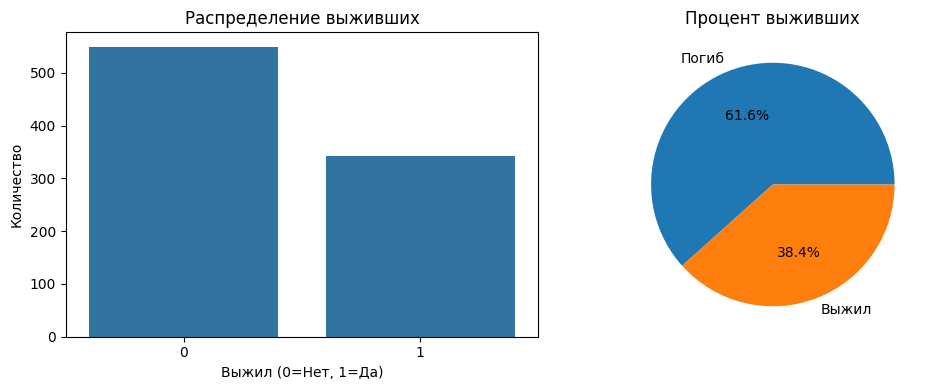

Статистики выживаемости:
Всего пассажиров: 891
Выжило: 342 (38.4%)
Погибло: 549 (61.6%)


In [ ]:
# Анализ целевой переменной
print("Анализ целевой переменной Survived:")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Survived')
plt.title('Распределение выживших')
plt.xlabel('Выжил (0=Нет, 1=Да)')
plt.ylabel('Количество')

plt.subplot(1, 3, 2)
survival_rate = df['Survived'].value_counts(normalize=True) * 100
plt.pie(survival_rate.values, labels=['Погиб', 'Выжил'], autopct='%1.1f%%')
plt.title('Процент выживших')

plt.tight_layout()
plt.show()

print("Статистики выживаемости:")
print(f"Всего пассажиров: {len(df)}")

survived_count = df['Survived'].astype('int').sum()
print(f"Выжило: {survived_count} ({survival_rate[1]:.1f}%)")
print(f"Погибло: {len(df) - survived_count} ({survival_rate[0]:.1f}%)")

In [ ]:
# Анализ пропусков
print("Анализ пропусков")
missing_data = df.isnull().sum()
print("Пропуски по колонкам:")
for col, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} пропусков ({missing_count/len(df)*100:.1f}%)")

# Обработка пропусков
print("")
print("Обработка пропусков")

# Age - заполняем медианным значением
age_median = df['Age'].median()
df['Age'] = df['Age'].fillna(age_median)
print(f"Заполнено {missing_data['Age']} пропусков в Age медианой: {age_median:.1f}")

# Embarked - заполняем модой (самым частым значением)
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(embarked_mode)
print(f"Заполнено {missing_data['Embarked']} пропусков в Embarked модой: {embarked_mode}")

# Cabin - слишком много пропусков, удаляем колонку
df = df.drop('Cabin', axis=1)
print("Удалена колонка Cabin (слишком много пропусков)")

print(f"Общее количество пропусков после обработки: {df.isnull().sum().sum()}")

Анализ пропусков
Пропуски по колонкам:
  Age: 177 пропусков (19.9%)
  Cabin: 687 пропусков (77.1%)
  Embarked: 2 пропусков (0.2%)

Обработка пропусков
Заполнено 177 пропусков в Age медианой: 28.0
Заполнено 2 пропусков в Embarked модой: S
Удалена колонка Cabin (слишком много пропусков)
Общее количество пропусков после обработки: 0


In [ ]:
#Создание бинарных признаков
# Бинаризируем Age на "дети" и "взрослые" (дети до 18 лет)
df['age_group'] = df['Age'].apply(
    lambda x: 'child' if x < 18 else 'adult'
)

# Бинаризируем Fare на "дешевые" и "дорогие" билеты
fare_median = df['Fare'].median()
df['fare_level'] = df['Fare'].apply(
    lambda x: 'expensive' if x > fare_median else 'cheap'
)

# Бинаризируем семейный статус
df['has_family'] = df.apply(
    lambda x: 'with_family' if (x['SibSp'] + x['Parch']) > 0 else 'alone',
    axis=1
)

print("Созданы бинарные признаки:")
print(f"  - age_group: {df['age_group'].unique()}")
print(f"  - fare_level: {df['fare_level'].unique()}")
print(f"  - has_family: {df['has_family'].unique()}")

# Преобразуем в категории
df['age_group'] = df['age_group'].astype('category')
df['fare_level'] = df['fare_level'].astype('category')
df['has_family'] = df['has_family'].astype('category')

Созданы бинарные признаки:
  - age_group: ['adult' 'child']
  - fare_level: ['cheap' 'expensive']
  - has_family: ['with_family' 'alone']


Анализ категориальных переменных Chi2:

Pclass vs Survived:
  χ² = 102.89, p-value = 4.55e-23
  Зависимость есть (p < 0.05)

Sex vs Survived:
  χ² = 260.72, p-value = 1.20e-58
  Зависимость есть (p < 0.05)

Embarked vs Survived:
  χ² = 25.96, p-value = 2.30e-06
  Зависимость есть (p < 0.05)

age_group vs Survived:
  χ² = 12.57, p-value = 3.92e-04
  Зависимость есть (p < 0.05)

fare_level vs Survived:
  χ² = 66.25, p-value = 3.98e-16
  Зависимость есть (p < 0.05)

has_family vs Survived:
  χ² = 36.00, p-value = 1.97e-09
  Зависимость есть (p < 0.05)


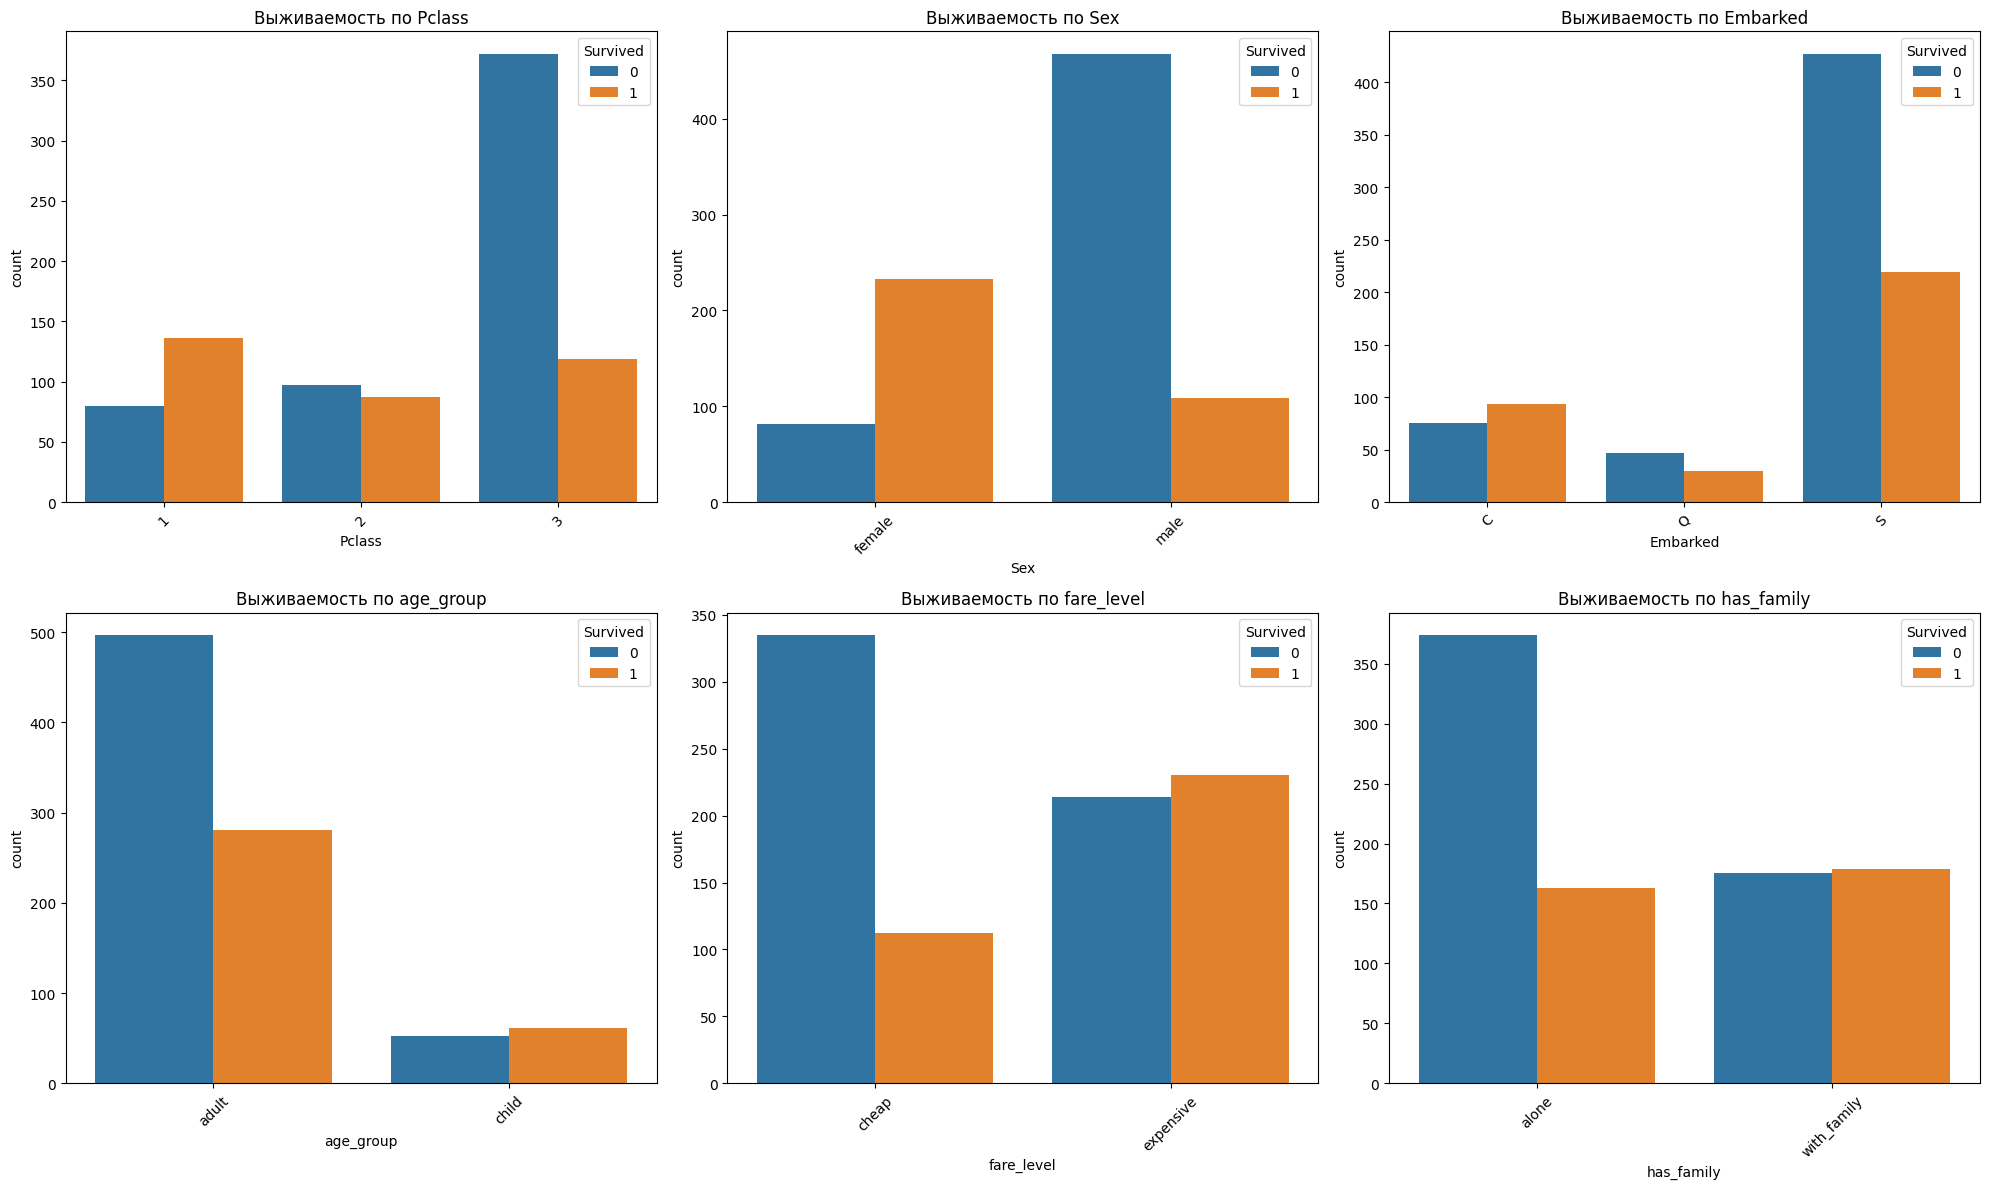

In [ ]:
#Анализ категориальных переменных с помощью Chi2
print("Анализ категориальных переменных Chi2:")

# Включаем дополнительные бинарные признаки в анализ
categorical_features = ['Pclass', 'Sex', 'Embarked', 'age_group', 'fare_level', 'has_family']

plt.figure(figsize=(20, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=feature, hue='Survived')
    plt.title(f'Выживаемость по {feature}')
    plt.xticks(rotation=45)

    # Chi2 тест
    table = pd.crosstab(df[feature], df['Survived'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"\n{feature} vs Survived:")
    print(f"  χ² = {chi2:.2f}, p-value = {p:.2e}")
    print(f"  Зависимость {'есть' if p < 0.05 else 'нет'} (p < 0.05)")


plt.tight_layout()
plt.show()

1. Pclass vs Survived: p-value = 0.000000000000000000000045.
Вывод: Класс билета очень сильно влияет на выживаемость

2. Sex vs Survived: p-value = 0.00000000000000000000000000000000000000000000000000000000012.
Вывод: Пол - самый сильный фактор выживания

3. Embarked vs Survived: p-value = 0.00000230. Вывод: Порт посадки влияет на выживаемость, но слабее чем пол или класс

4. age_group vs Survived: p-value = 0.000392. Вывод: Возрастная группа (дети/взрослые) влияет на выживаемость

5. fare_level vs Survived: p-value = 0.000000000000000398. Вывод: Цена билета сильно влияет на выживаемость

6. has_family vs Survived: p-value = 0.00000000197 Вывод: Наличие семьи влияет на выживаемость

Иерархия влияния:

Sex (χ² = 260.72)

Pclass (χ² = 102.89)

fare_level (χ² = 66.25)

has_family (χ² = 36.00)

Embarked (χ² = 25.96)

age_group (χ² = 12.57)

Анализ числовых переменных:


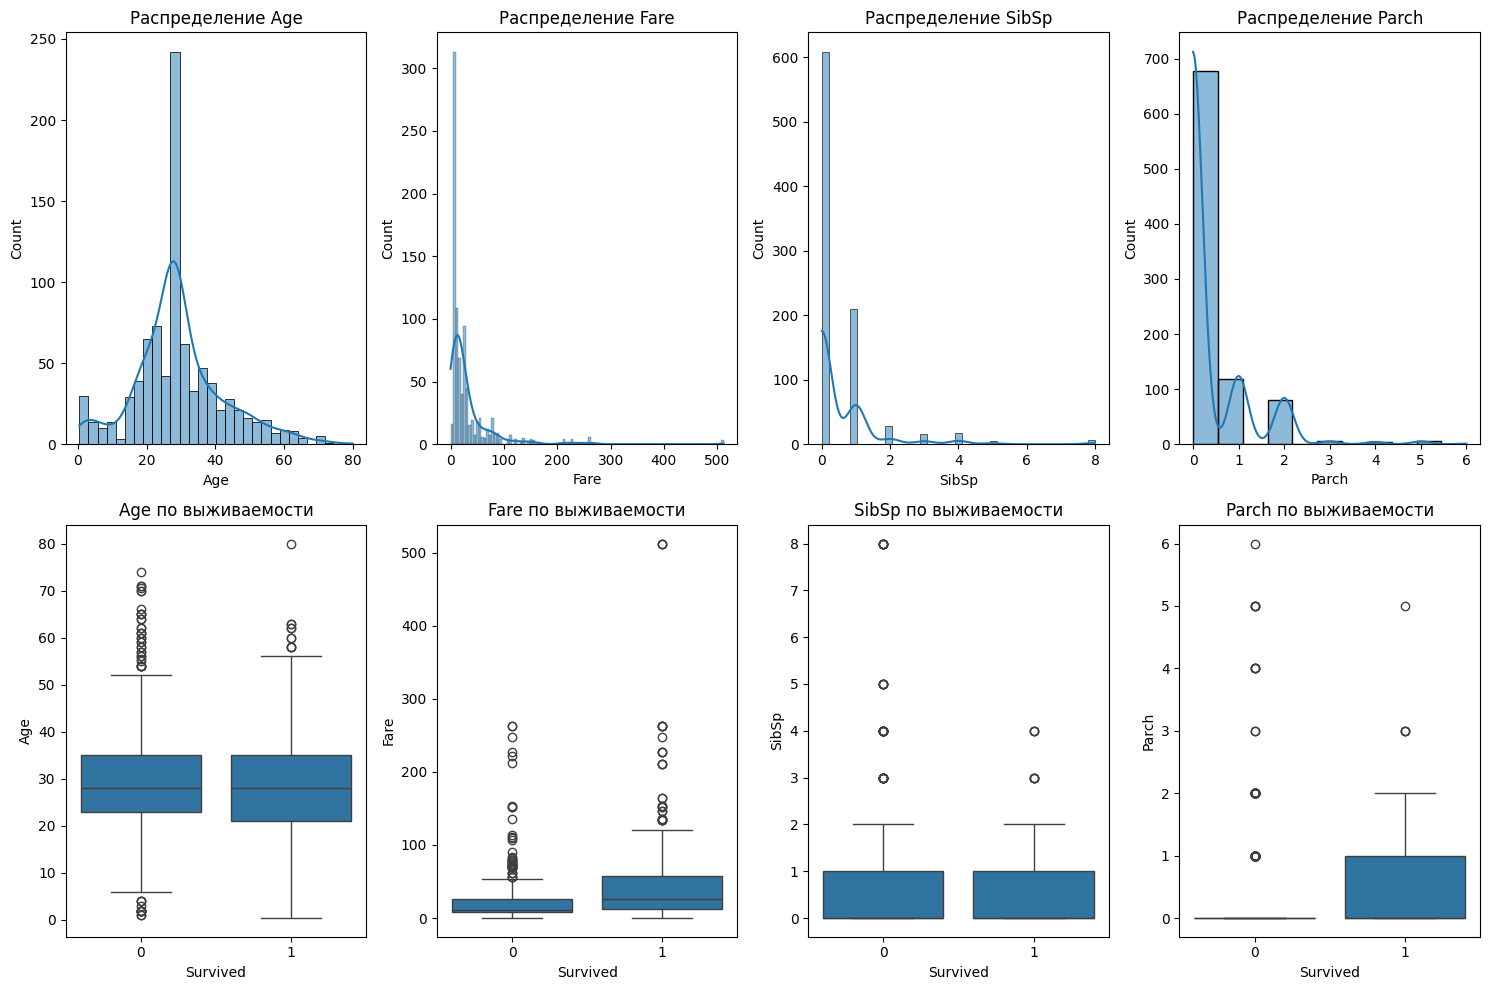


КОРРЕЛЯЦИЯ С ВЫЖИВАЕМОСТЬЮ:
Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Name: Survived, dtype: float64


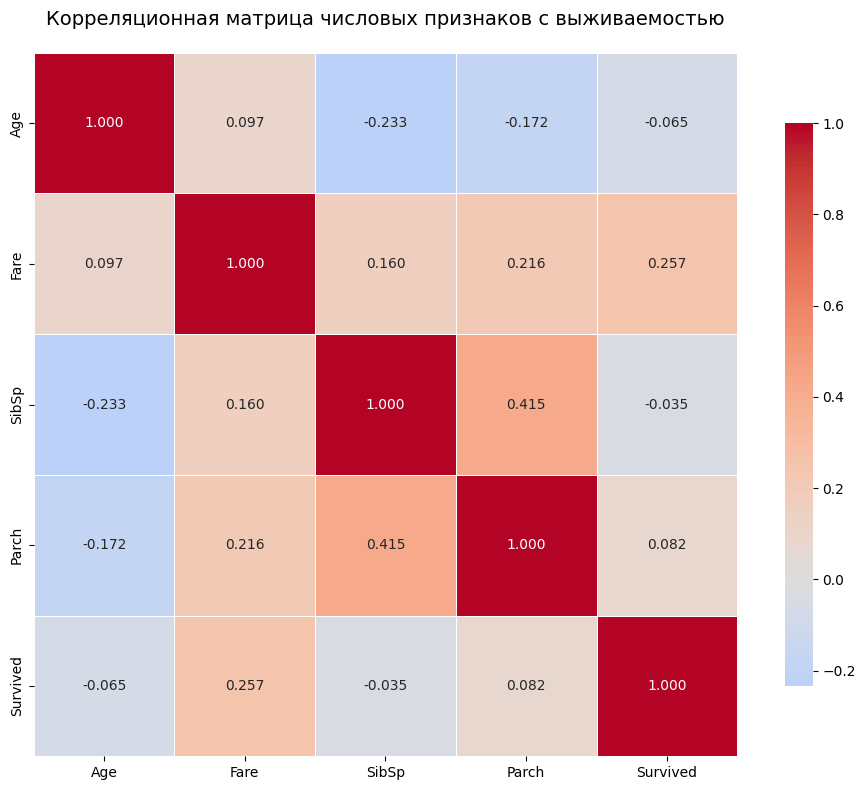

In [ ]:
print("Анализ числовых переменных:")

numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

plt.figure(figsize=(15, 10))

# Распределение числовых признаков
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f'Распределение {feature}')

# Boxplot по выживаемости
for i, feature in enumerate(numerical_features, 5):
    plt.subplot(2, 4, i)
    sns.boxplot(data=df, x='Survived', y=feature)
    plt.title(f'{feature} по выживаемости')

plt.tight_layout()
plt.show()

# Корреляционный анализ
print("\nКОРРЕЛЯЦИЯ С ВЫЖИВАЕМОСТЬЮ:")
# Временно преобразуем категориальные в числовые для корреляции
corr_df = df.copy()
corr_df['Survived'] = corr_df['Survived'].astype('int')
corr_df['Sex'] = corr_df['Sex'].cat.codes
correlation_with_target = corr_df[numerical_features + ['Survived']].corr()['Survived'].sort_values(ascending=False)
print(correlation_with_target)

# Создаем корреляционную матрицу для числовых признаков + Survived
correlation_matrix = corr_df[numerical_features + ['Survived']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.3f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Корреляционная матрица числовых признаков с выживаемостью', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Выводы по боксплотам:

Fare-больше выбросов среди погибших = пассажиры с очень дорогими билетами, но которые не выжили. Были очень богатые пассажиры, которые все равно погибли. Деньги помогали, но не гарантировали спасение.

Age-много выбросов среди погибших,пожилые пассажиры имели очень низкие шансы

SibSp/parch-большие семьи имели проблемы с эвакуацией

Матрица корреляции:

Положительная корреляция наблюдается только с Fare (0.257), из чего можно сделать вывод что деньги помогали, но все же не решали все.

In [ ]:
# Выбор лучших признаков
best_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

### Нормализация данных



Признаки для модели: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Размерность X: (891, 7)

Статистики до нормализации:
              Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000
mean    29.361582    0.523008    0.381594   32.204208
std     13.019697    1.102743    0.806057   49.693429
min      0.420000    0.000000    0.000000    0.000000
25%     22.000000    0.000000    0.000000    7.910400
50%     28.000000    0.000000    0.000000   14.454200
75%     35.000000    1.000000    0.000000   31.000000
max     80.000000    8.000000    6.000000  512.329200

Размерность после обработки: (891, 12)

Первые 5 строк обработанных данных:
        Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  Pclass_3  \
0 -0.565736  0.432793 -0.473674 -0.502445       0.0       0.0       1.0   
1  0.663861  0.432793 -0.473674  0.786845       1.0       0.0       0.0   
2 -0.258337 -0.474545 -0.473674 -0.488854       0.0       0.0       1.0   


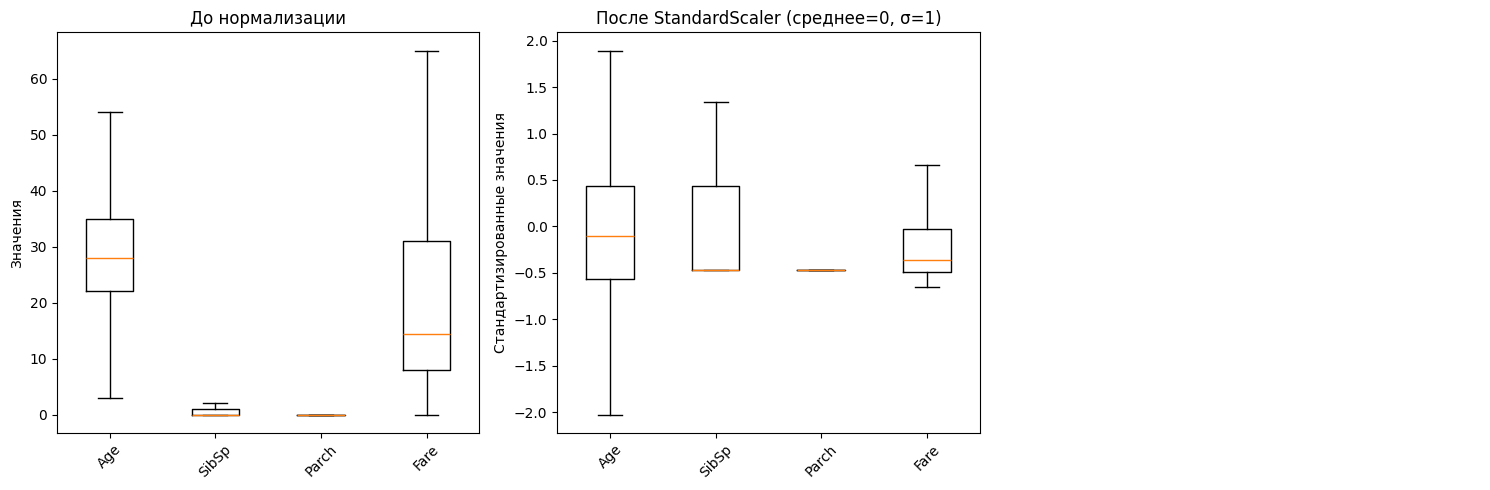


Статистики после нормализации:
                Age         SibSp         Parch          Fare
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean   2.272780e-16  4.386066e-17  5.382900e-17  3.987333e-18
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -2.224156e+00 -4.745452e-01 -4.736736e-01 -6.484217e-01
25%   -5.657365e-01 -4.745452e-01 -4.736736e-01 -4.891482e-01
50%   -1.046374e-01 -4.745452e-01 -4.736736e-01 -3.573909e-01
75%    4.333115e-01  4.327934e-01 -4.736736e-01 -2.424635e-02
max    3.891554e+00  6.784163e+00  6.974147e+00  9.667167e+00
OneHotEncoded признаки:
  Pclass_1: [0. 1.]
  Pclass_2: [0. 1.]
  Pclass_3: [1. 0.]
  Sex_female: [0. 1.]
  Sex_male: [1. 0.]
  Embarked_C: [0. 1.]
  Embarked_Q: [0. 1.]
  Embarked_S: [1. 0.]


In [ ]:
# Оставляем выбранные признаки
selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df[selected_features].copy()
y = df['Survived']

print(f"Признаки для модели: {selected_features}")
print(f"Размерность X: {X.shape}")

# Разделяем на числовые и категориальные признаки
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Создаем копию только с числовыми признаками для визуализации
num_df = X[numerical_features].copy()

# Статистики до нормализации
print("\nСтатистики до нормализации:")
print(num_df.describe())

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

# Применяем преобразования
X_processed = preprocessor.fit_transform(X)

# Получаем имена фичей после OneHotEncoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Объединяем все имена признаков
feature_names = numerical_features + cat_feature_names.tolist()

# Создаем DataFrame с обработанными данными
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print(f"\nРазмерность после обработки: {X_processed_df.shape}")
print("\nПервые 5 строк обработанных данных:")
print(X_processed_df.head())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# До нормализации
axes[0].boxplot(num_df.values, showfliers=False)
axes[0].set_title("До нормализации")
axes[0].set_xticks(range(1, len(num_df.columns)+1))
axes[0].set_xticklabels(num_df.columns, rotation=45)
axes[0].set_ylabel("Значения")

# После StandardScaler (только числовые признаки)
numerical_scaled = X_processed_df[numerical_features].copy()

axes[1].boxplot(numerical_scaled.values, showfliers=False)
axes[1].set_title("После StandardScaler (среднее=0, σ=1)")
axes[1].set_xticks(range(1, len(numerical_scaled.columns)+1))
axes[1].set_xticklabels(numerical_scaled.columns, rotation=45)
axes[1].set_ylabel("Стандартизированные значения")

# Оставляем третью ось пустой для симметрии
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Статистики после нормализации
print("\nСтатистики после нормализации:")
print(pd.DataFrame(numerical_scaled, columns=numerical_features).describe())

print("OneHotEncoded признаки:")
for feature in cat_feature_names:
    unique_vals = X_processed_df[feature].unique()
    print(f"  {feature}: {unique_vals}")

### Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Метрики для обучающая выборка 
Accuracy:  0.8042
Precision: 0.7671
Recall:    0.7029
F1-score:  0.7336
ROC-AUC:   0.8585

Confusion Matrix:
[[333  51]
 [ 71 168]]


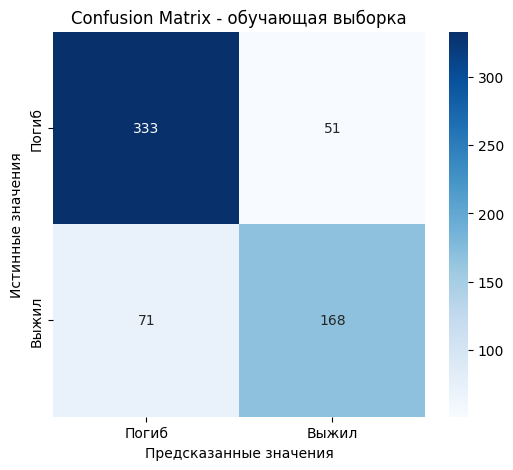

Метрики для тестовая выборка 
Accuracy:  0.7948
Precision: 0.7449
Recall:    0.7087
F1-score:  0.7264
ROC-AUC:   0.8484

Confusion Matrix:
[[140  25]
 [ 30  73]]


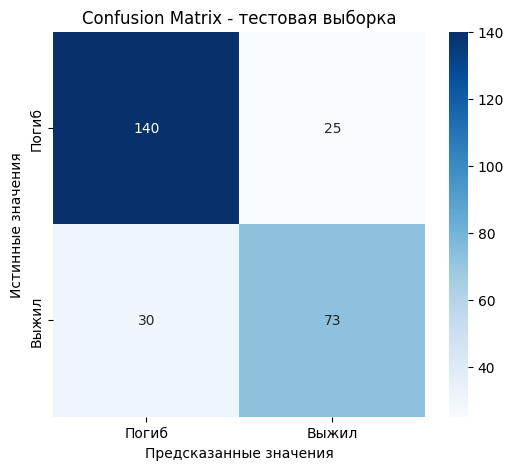


Коэффициенты модели (отсортированы по влиянию):
   Признак  Коэффициент  Абс_коэффициент
Sex_female     1.421149         1.421149
  Sex_male    -1.277594         1.277594
  Pclass_1     1.130779         1.130779
  Pclass_3    -1.093327         1.093327
       Age    -0.559961         0.559961
Embarked_Q     0.357247         0.357247
     SibSp    -0.349796         0.349796
Embarked_S    -0.263758         0.263758
      Fare     0.120431         0.120431
  Pclass_2     0.106104         0.106104
     Parch    -0.052657         0.052657
Embarked_C     0.050066         0.050066


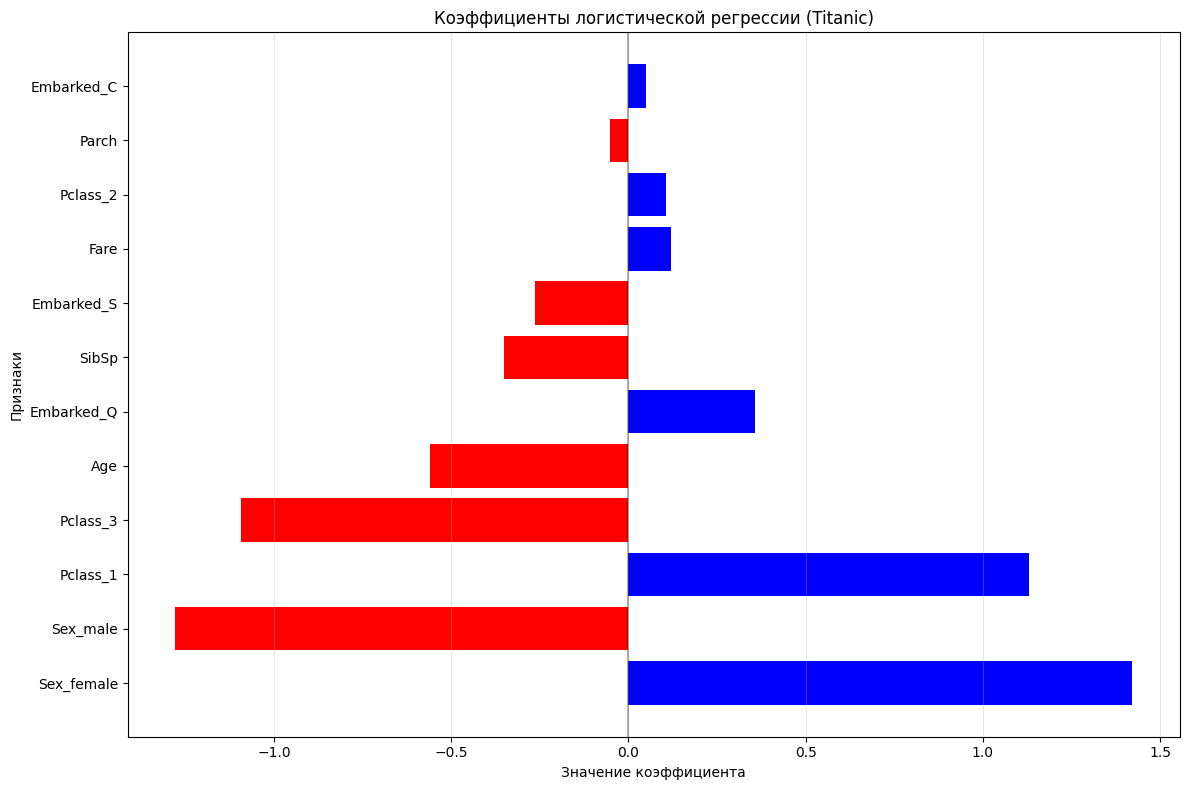

Положительные коэффициенты УВЕЛИЧИВАЮТ вероятность ВЫЖИТЬ
Отрицательные коэффициенты УМЕНЬШАЮТ вероятность ВЫЖИТЬ
Самые важные признаки для предсказания выживания:
  Sex_female          : УВЕЛИЧИВАЕТ вероятность выживания (коэф: 1.421)
  Sex_male            : УМЕНЬШАЕТ вероятность выживания (коэф: -1.278)
  Pclass_1            : УВЕЛИЧИВАЕТ вероятность выживания (коэф: 1.131)
  Pclass_3            : УМЕНЬШАЕТ вероятность выживания (коэф: -1.093)
  Age                 : УМЕНЬШАЕТ вероятность выживания (коэф: -0.560)
Accuracy на обучении:  0.8042
Accuracy на тесте:    0.7948
Модель хорошо обобщает (малая разница)

Качество модели на тестовых данных: 79.5%


In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.3, random_state=42, stratify=y
)

# Модель
model = LogisticRegression(penalty=None, random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Предсказания
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)

# Функция оценки
def evaluate_classification(y_true, y_pred, y_proba=None, dataset_name=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    roc_auc = roc_auc_score(y_true, y_proba[:, 1]) if y_proba is not None else None

    cm = confusion_matrix(y_true, y_pred)

    print(f"Метрики для {dataset_name} ")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Визуализация
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Погиб', 'Выжил'],
                yticklabels=['Погиб', 'Выжил'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc_auc, "confusion_matrix": cm}

train_metrics = evaluate_classification(y_train, y_train_pred, y_train_proba, "обучающая выборка")
test_metrics = evaluate_classification(y_test, y_test_pred, y_test_proba, "тестовая выборка")

# Создаем DataFrame с коэффициентами
coefficients_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': model.coef_[0]
})

# Сортируем по абсолютному значению коэффициента
coefficients_df['Абс_коэффициент'] = np.abs(coefficients_df['Коэффициент'])
coefficients_df = coefficients_df.sort_values('Абс_коэффициент', ascending=False)

print("\nКоэффициенты модели (отсортированы по влиянию):")
print(coefficients_df.to_string(index=False))

# Визуализация коэффициентов
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in coefficients_df['Коэффициент']]
plt.barh(coefficients_df['Признак'], coefficients_df['Коэффициент'], color=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.title('Коэффициенты логистической регрессии (Titanic)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Положительные коэффициенты УВЕЛИЧИВАЮТ вероятность ВЫЖИТЬ")
print("Отрицательные коэффициенты УМЕНЬШАЮТ вероятность ВЫЖИТЬ")
print("Самые важные признаки для предсказания выживания:")

top_features = coefficients_df.head(5)
for _, row in top_features.iterrows():
    effect = "УВЕЛИЧИВАЕТ" if row['Коэффициент'] > 0 else "УМЕНЬШАЕТ"
    print(f"  {row['Признак']:20}: {effect} вероятность выживания (коэф: {row['Коэффициент']:.3f})")

# Сравнение метрик обучающей и тестовой выборок
print(f"Accuracy на обучении:  {train_metrics['accuracy']:.4f}")
print(f"Accuracy на тесте:    {test_metrics['accuracy']:.4f}")

if train_metrics['accuracy'] > test_metrics['accuracy'] + 0.05:
    print("Возможное переобучение (разница > 5%)")
else:
    print("Модель хорошо обобщает (малая разница)")

print(f"\nКачество модели на тестовых данных: {test_metrics['accuracy']:.1%}")

# **Выводы:**
**Общая эффективность модели**

Accuracy (точность классификаций): 79.5% - модель правильно предсказывает судьбу пассажиров в 4 из 5 случаев. Хороший результат

Стабильность модели: Разница между обучающей (80.4%) и тестовой (79.5%) точностью всего 0.9% - модель не переобучилась и хорошо обобщает на новых данных.

**Детальный анализ метрик**

На обучающих данных:

Precision (76.7%): Из всех предсказанных "выживших" 76.7% действительно выжили

Recall (70.3%): Модель нашла 70.3% от всех реально выживших

F1-score (73.4%): Сбалансированная метрика между точностью и полнотой

ROC-AUC (85.9%): Хорошая способность различать классы

На тестовых данных:
Метрики немного ниже,, но модель сохраняет хорошее качество.

**Основные ошибки модели:**

25 случаев: Модель сказала "выжил", но пассажир погиб (False Positive)

30 случаев: Модель сказала "погиб", но пассажир выжил (False Negative)

**Ключевые факторы выживания**

1. Пол (Sex) - Наиболее влиятельный фактор
Sex_female (+1.421): Быть женщиной увеличивает шанс выжить
Sex_male (-1.278): Быть мужчиной уменьшает шанс выжить
(На Титанике действительно применялся принцип "женщины и дети первыми")

2. Класс каюты (Pclass) - второй по важности
Pclass_1 (+1.131): Билет 1-го класса увеличивает шанс выжить,
Pclass_3 (-1.093): Билет 3-го класса уменьшает шанс выжить,
Pclass_2 (+0.106): Слабое положительное влияние
(Пассажиры 1-го класса имели приоритет к шлюпкам и находились ближе к палубе)

3. Возраст (Age) - третий по влиянию
Age (-0.560): С увеличением возраста шанс выжить уменьшается
(Молодые люди были физически сильнее и имели приоритет по принципу "женщины и дети первыми")

